"""

ISFC

Rui Pei 8/17/2017

Add description

Required package:
gensim, nltk, numpy

"""

In [68]:
import os, re
import numpy
import numpy as np
from scipy import stats
from scipy import math

from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def compute_correlation(matrix1, matrix2):
    """compute correlation between two sets of variables

    Correlate the rows of matrix1 with the rows of matrix2.
    If matrix1 == matrix2, it is auto-correlation computation
    resulting in a symmetric correlation matrix.
    The number of columns MUST agree between set1 and set2.
    The correlation being computed here is
    the Pearson's correlation coefficient, which can be expressed as

    .. math:: corr(X, Y) = \\frac{cov(X, Y)}{\\sigma_X\\sigma_Y}

    where cov(X, Y) is the covariance of variable X and Y, and

    .. math:: \\sigma_X

    is the standard deviation of variable X

    Reducing the correlation computation to matrix multiplication
    and using BLAS GEMM API wrapped by Scipy can speedup the numpy built-in
    correlation computation (numpy.corrcoef) by one order of magnitude

    .. math::
        corr(X, Y)
        &= \\frac{\\sum\\limits_{i=1}^n (x_i-\\bar{x})(y_i-\\bar{y})}{(n-1)
        \\sqrt{\\frac{\\sum\\limits_{j=1}^n x_j^2-n\\bar{x}}{n-1}}
        \\sqrt{\\frac{\\sum\\limits_{j=1}^{n} y_j^2-n\\bar{y}}{n-1}}}\\\\
        &= \\sum\\limits_{i=1}^n(\\frac{(x_i-\\bar{x})}
        {\\sqrt{\\sum\\limits_{j=1}^n x_j^2-n\\bar{x}}}
        \\frac{(y_i-\\bar{y})}{\\sqrt{\\sum\\limits_{j=1}^n y_j^2-n\\bar{y}}})

    Parameters
    ----------
    matrix1: 2D array in shape [r1, c]
        MUST be continuous and row-major

    matrix2: 2D array in shape [r2, c]
        MUST be continuous and row-major

    Returns
    -------
    corr_data: 2D array in shape [r1, r2]
        continuous and row-major in np.float32
    """
    matrix1 = matrix1.astype(np.float32)
    matrix2 = matrix2.astype(np.float32)
    [r1, d1] = matrix1.shape
    [r2, d2] = matrix2.shape
    if d1 != d2:
        raise ValueError('Dimension discrepancy')
    # preprocess two components
    matrix1 = _normalize_for_correlation(matrix1, 1)
    matrix2 = _normalize_for_correlation(matrix2, 1)
    #print(matrix1.shape)
    #print(matrix2.shape)
    corr_data = np.corrcoef(matrix1, matrix2)
    #print(corr_data.shape)
    #print(d1)
    return corr_data[:r1, r1:]   ###I Believe this is the critical part! we need to fix this and then should be fine
    #According to my understanding, the submatrices AAA[0:90, 0:90]  and AAA[90:,90:] will be the respective "intra-brain" 
    #correlations. What we want is the one that goes across brains, i.e. the lower/upper quadrant. This should be relatively
    #easy to formalize. i.e. corr_data[:r1, r1:]  should be 0:90 rows, but 90:180 columns, which should be the across brain computation.



def _normalize_for_correlation(data, axis):
    """normalize the data before computing correlation
    The data will be z-scored and divided by sqrt(n)
    along the assigned axis
    Parameters
    ----------
    data: 2D array
    axis: int
        specify which dimension of the data should be normalized
    Returns
    -------
    data: 2D array
        the normalized data
    """
    shape = data.shape
    data = zscore(data, axis=axis, ddof=0)
    # if zscore fails (standard deviation is zero),
    # set all values to be zero
    data = np.nan_to_num(data)
    data = data / math.sqrt(shape[axis])
    return data



def isc(D, collapse_subj=True):
    """Intersubject correlation

    For each voxel, computes the correlation of each subject's timecourse with
    the mean of all other subjects' timecourses. By default the result is
    averaged across subjects, unless collapse_subj is set to False.

    Parameters
    ----------
    D : voxel by time by subject ndarray
        fMRI data for which to compute ISC

    collapse_subj : bool, default:True
        Whether to average across subjects before returning result

    Returns
    -------
    ISC : voxel ndarray (or voxel by subject ndarray, if collapse_subj=False)
        pearson correlation for each voxel, across subjects
    """

    n_vox = D.shape[0]
    n_subj = D.shape[2]
    ISC = np.zeros((n_vox, n_subj))

    # Loop across choice of leave-one-out subject
    for loo_subj in range(n_subj):
        group = np.mean(D[:, :, np.arange(n_subj) != loo_subj], axis=2)
        subj = D[:, :, loo_subj]
        for v in range(n_vox):
            ISC[v, loo_subj] = stats.pearsonr(group[v, :], subj[v, :])[0]

    if collapse_subj:
        ISC = np.mean(ISC, axis=1)
    return ISC


def isfc(D, collapse_subj=True):
    """Intersubject functional correlation
    Computes the correlation between the timecoure of each voxel in each
    subject with the average of all other subjects' timecourses in *all*
    voxels. By default the result is averaged across subjects, unless
    collapse_subj is set to False.
    Uses the high performance compute_correlation routine from fcma.util
    Parameters
    ----------
    D : voxel by time by subject ndarray
        fMRI data for which to compute ISFC
    collapse_subj : bool, default:True
        Whether to average across subjects before returning result
    Returns
    -------
    ISFC : voxel by voxel ndarray
        (or voxel by voxel by subject ndarray, if collapse_subj=False)
        pearson correlation between all pairs of voxels, across subjects
    """

    n_vox = D.shape[0]
    n_subj = D.shape[2]
    ISFC = np.zeros((n_vox, n_vox, n_subj))

    # Loop across choice of leave-one-out subject
    for loo_subj in range(D.shape[2]):
        group = np.mean(D[:, :, np.arange(n_subj) != loo_subj], axis=2)
        subj = D[:, :, loo_subj]
        ISFC[:, :, loo_subj] = compute_correlation(group, subj)

        # Symmetrize matrix
        ISFC[:, :, loo_subj] = (ISFC[:, :, loo_subj] +
                                ISFC[:, :, loo_subj].T) / 2

    if collapse_subj:
        ISFC = np.mean(ISFC, axis=2)
    return ISFC


In [41]:
networks_labels = [' anterior_Salience1', ' anterior_Salience2', ' anterior_Salience3', ' anterior_Salience4', ' anterior_Salience5', ' anterior_Salience6', ' anterior_Salience7', ' Auditory1', ' Auditory2', ' Auditory3', ' Basal_Ganglia1', ' Basal_Ganglia2', ' Basal_Ganglia3', ' Basal_Ganglia4', ' Basal_Ganglia5', ' dorsal_DMN1', ' dorsal_DMN2', ' dorsal_DMN3', ' dorsal_DMN4', ' dorsal_DMN5', ' dorsal_DMN6', ' dorsal_DMN7', ' dorsal_DMN8', ' dorsal_DMN9', ' high_Visual1', ' high_Visual2', ' Language1', ' Language2', ' Language3', ' Language4', ' Language5', ' Language6', ' Language7', ' LECN1', ' LECN2', ' LECN3', ' LECN4', ' LECN5', ' LECN6', ' post_Salience1', ' post_Salience2', ' post_Salience3', ' post_Salience4', ' post_Salience5', ' post_Salience6', ' post_Salience7', ' post_Salience8', ' post_Salience9', ' post_Salience10', ' post_Salience11', ' post_Salience12', ' Precuneus1', ' Precuneus2', ' Precuneus3', ' Precuneus4', ' prim_Visual1', ' prim_Visual2', ' RECN1', ' RECN2', ' RECN3', ' RECN4', ' RECN5', ' RECN6', ' Sensorimotor1', ' Sensorimotor2', ' Sensorimotor3', ' Sensorimotor4', ' Sensorimotor5', ' Sensorimotor6', ' ventral_DMN1', ' ventral_DMN2', ' ventral_DMN3', ' ventral_DMN4', ' ventral_DMN5', ' ventral_DMN6', ' ventral_DMN7', ' ventral_DMN8', ' ventral_DMN9', ' ventral_DMN10', ' Visuospatial1', ' Visuospatial2', ' Visuospatial3', ' Visuospatial4', ' Visuospatial5', ' Visuospatial6', ' Visuospatial7', ' Visuospatial8', ' Visuospatial9', ' Visuospatial10', ' Visuospatial11']

In [154]:
networks = {"anterior_salience":[0,6], "anterior_salience": [0, 6], "auditory": [7, 9],
"basal ganglia": [10,14], "Dorsal_DMN": [15 , 23], "LECN": [33, 38], "RECN": [57, 62], "Precuneus": [51, 54]}


In [175]:
data_dir = '/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/shirer90spheres8mm/'

os.chdir(data_dir)
subjs = ['PSA156', 'PSA019', 'PSA144', 'PSA061', 'PSA120', 'PSA032', 'PSA041', 'PSA079', 'PSA029', 
         'PSA036', 'PSA078', 'PSA086', 'PSA131', 'PSA132', 'PSA153', 'PSA112', 'PSA056', 'PSA068', 
         'PSA075', 'PSA108', 'PSA003', 'PSA005', 'PSA007', 'PSA008', 'PSA009', 'PSA010', 'PSA016', 
         'PSA017', 'PSA026', 'PSA027', 'PSA028', 'PSA030', 'PSA109', 'PSA069', 'PSA119', 'PSA128', 
         'PSA142', 'PSA094', 'PSA151', 'PSA127']

tr = 31
os.listdir(data_dir)

['ISC_dict.npy',
 'PSA003_10_realcost01.npz',
 'PSA003_11_realcost01.npz',
 'PSA003_12_realcost01.npz',
 'PSA003_1_realcost01.npz',
 'PSA003_2_realcost01.npz',
 'PSA003_3_realcost01.npz',
 'PSA003_4_realcost01.npz',
 'PSA003_5_realcost01.npz',
 'PSA003_6_realcost01.npz',
 'PSA003_7_realcost01.npz',
 'PSA003_8_realcost01.npz',
 'PSA003_9_realcost01.npz',
 'PSA005_10_realcost01.npz',
 'PSA005_11_realcost01.npz',
 'PSA005_12_realcost01.npz',
 'PSA005_1_realcost01.npz',
 'PSA005_2_realcost01.npz',
 'PSA005_3_realcost01.npz',
 'PSA005_4_realcost01.npz',
 'PSA005_5_realcost01.npz',
 'PSA005_6_realcost01.npz',
 'PSA005_7_realcost01.npz',
 'PSA005_8_realcost01.npz',
 'PSA005_9_realcost01.npz',
 'PSA007_10_realcost01.npz',
 'PSA007_11_realcost01.npz',
 'PSA007_12_realcost01.npz',
 'PSA007_1_realcost01.npz',
 'PSA007_2_realcost01.npz',
 'PSA007_3_realcost01.npz',
 'PSA007_4_realcost01.npz',
 'PSA007_5_realcost01.npz',
 'PSA007_6_realcost01.npz',
 'PSA007_7_realcost01.npz',
 'PSA007_8_realcost01.

In [114]:
def psa_isfc(pID, vID):
    same_spots = [s for s in os.listdir(data_dir) if s.endswith('_' + vID + '_realcost01.npz')]

    #re-load extracted data
    data_list = []
    for i in same_spots:
        d = np.load(i)
        data_list.append(d['arr_0'][:tr,:])
    
    #stack them into a 3d array and set up array to have the dimenion order that ISFC wants
    spot_data  = np.asarray(data_list)  
    #    D : voxel by time by subject ndarray = that's what ISFC wants - so let's swap axes
    spot_data_v_t_s = spot_data.swapaxes(0,2)
    spot_data_v_t_s.shape

    result_isfc = isfc(spot_data_v_t_s, collapse_subj= False)
    
    return(result_isfc[:,:,subjs.index(pID)])

In [115]:
def ind_isfc(pID):
    data_list = []
    for i in range(12):
        data_list.append(psa_isfc(pID, str(i+1)))
    pid_data  = np.mean(np.asarray(data_list), axis = 0)
    return pid_data

In [130]:
def isfc_network(pID, vID, network_idx):
    whole_matrix = psa_isfc(pID, vID)
    network_matrix = whole_matrix[network_idx[0]:(network_idx[1] + 1), network_idx[0]: (network_idx[1]+1)]
    network_matrix_mean = np.mean(network_matrix[np.triu_indices(network_idx[1] - network_idx[0] + 1)])
    return network_matrix_mean
    

array([[-0.11081588, -0.2734987 , -0.08386422, ..., -0.42424656,
        -0.33666452,  0.12375419],
       [-0.2734987 , -0.28089761, -0.18990205, ..., -0.47307912,
        -0.35008789,  0.00169009],
       [-0.08386422, -0.18990205, -0.02668698, ..., -0.34558654,
        -0.23210961,  0.22867487],
       ..., 
       [-0.42424656, -0.47307912, -0.34558654, ..., -0.46987456,
        -0.43988351, -0.11208859],
       [-0.33666452, -0.35008789, -0.23210961, ..., -0.43988351,
        -0.31313549,  0.02603128],
       [ 0.12375419,  0.00169009,  0.22867487, ..., -0.11208859,
         0.02603128,  0.50594706]])

In [142]:
subj_norm_pos_change = ['PSA010','PSA079', 'PSA094', 'PSA131', 'PSA132', 'PSA142']
subj_norm_neg_change = ['PSA005', 'PSA029',  'PSA086']
subj_norm_no_change = [subj for subj in subjs if subj not in list(set(subj_norm_pos_change + subj_norm_neg_change))]

In [158]:
networks[key]

[0, 6]

In [172]:

key = 'Precuneus'
isfc_pos_change = []
isfc_no_change = []
isfc_neg_change = []
for subj in subj_norm_no_change:
    a = 0
    for i in range(12):
        print(i)
        a = a + isfc_network(subj, str(i+1), networks[key])
    isfc_no_change =  np.append(isfc_no_change, a/12)
    #plt.imshow(ind_isfc(subj), interpolation='none',cmap='RdBu_r', );
for subj in subj_norm_pos_change:
    a = 0
    for i in range(12):
        a = a + isfc_network(subj, str(i+1), networks[key])
    isfc_pos_change =  np.append(isfc_pos_change, a/12)
    #plt.imshow(ind_isfc(subj), interpolation='none',cmap='RdBu_r', );
    


0
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 3

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
8
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
3
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
10
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
3

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
3
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
10
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 18

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
3
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
11
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
3

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
6
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(180, 180)
31
(4, 4)
1
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
3
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
10
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 18

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
8
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
11
(90, 31)
(90, 31)
(180, 180)
3

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 18

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
2
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
1

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
5
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
7
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
3
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
11
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
3

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 18

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
2
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
4
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
2
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
8
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
3
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
6
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 18

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(

31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(4, 4)
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
3

In [173]:
scipy.stats.ttest_ind(isfc_pos_change,isfc_no_change)




Ttest_indResult(statistic=1.1909786408892478, pvalue=0.24167655867928126)

In [150]:
dDMN_pos_change = dDMN

In [153]:
scipy.stats.ttest_ind(dDMN_no_change,dDMN_pos_change)

Ttest_indResult(statistic=-0.47204523555443439, pvalue=0.63982439631322641)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)

(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)

(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 180)
31
(90, 31)
(90, 31)
(180, 18

ValueError: 'PSA038' is not in list

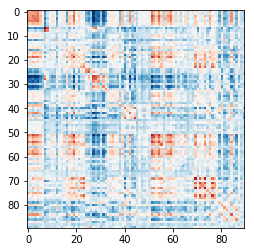

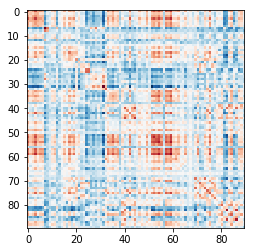

In [123]:
for subj in subj_norm_neg_change:
    fig = plt.figure()
    plt.imshow(ind_isfc(subj), interpolation='none',cmap='RdBu_r', );

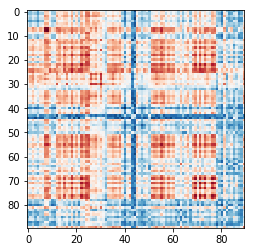

In [111]:
plt.imshow(a, interpolation='none',cmap='RdBu_r', );

* calculate the ISFC in DMN network

In [76]:
dDMN = result_isfc[15:24,15:24,5]

In [78]:
np.mean(dDMN[np.triu_indices(8)])

0.067713245483431536

In [79]:
np.mean(dDMN)

0.066343986746660769

In [174]:
import pickle
networks_file      =  '/data00/projects/project1/scripts/ipython/data_dec/networks_coords_names.pckl'

with open(networks_file, "rb") as f:
    networks_labels, networks_coords, networks_inds,module_idx, breakpoints, network_borders, \
    netnames, bounds, bp, textlocs, networks_xyz_coords,  cmap_list, col_vec  = pickle.load(f)
n_nodes = len(networks_coords) 

from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=(7,7))
ax1 = plt.subplot(111) 

im3 = ax1.imshow(result_isfc[:,:,9],interpolation='none',cmap='RdBu_r', vmax = 0.8, vmin=-0.6);
ax1.set_title('TestSpot ISFC');

bounds = bp


ax1.grid(False);
divider3 = make_axes_locatable(ax1)
    # Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="2%", pad=0.05)
    # Create colorbar in the appended axes
    # Tick locations can be set with the kwarg `ticks`
    # and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=MultipleLocator(0.2), format="%.2f")
    
#ax.colorbar(shrink=0.5);
ax1.set_yticks(textlocs);
ax1.set_yticklabels(netnames,fontsize=12);
ax1.set_xticks(textlocs);
ax1.set_xticklabels(netnames,fontsize=12,rotation=90);    


for b in bounds:
        ax1.axvline(x=b,color='green', linewidth = 1.75)
        ax1.axhline(y=b,color='green', linewidth = 1.75)


plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/data00/projects/project1/scripts/ipython/data_dec/networks_coords_names.pckl'